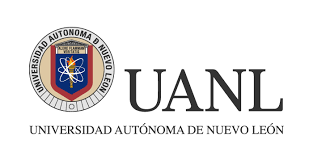
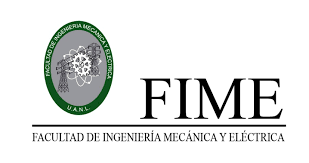

#**Inteligencia Artificial y redes Neuronales**
#**Producto Integrador de aprendizaje**

**Integrantes** 

Christian Eduwiges Carranza Cabrales   **Maricula:**1889205     **Carrera:** IMTC

José Luis Gutiérrez Mendoza            **Matricula:**1800780    **Carrera:**IMTC

Luis Fernando Garza Esparza            **Matrícula: 1856813**   **Carrera:**IMTC

# Importar dataset desde Kaggle

In [ ]:
#Install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"carranza117","key":"9d96401d747f71f719dcc299ef2590a8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9191  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5633  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2041  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2404  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip intel-image-classification.zip

# Importar librerias

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D

# Preprocesamiento de los Datos

Los "aumentaremos" mediante una serie de transformaciones aleatorias, esto ayuda a prevenir el sobreajuste y ayuda a que el modelo generalice mejor.

Se le asigna un path a cada carpeta en forma de string, para ser concatenado posteriormente

In [ ]:
seg_train = '/content/seg_train/seg_train'  
seg_test = '/content/seg_test/seg_test'
seg_pred = '/content/seg_pred/seg_pred'

En cada Época, el ImageDataGenerator aplica una transformación en las imágenes que tiene y usa el Imágenes transformadas para entrenamiento. El conjunto de transformaciones incluye rotación, zoom, etc. Al hacer esto, de alguna manera está creando datos nuevos.

**ImageDataGenerator** es una clase de preprocesamiento de imágenes en Keras. Se utiliza para generar lotes de datos con aumento de datos en tiempo real.

In [ ]:
generate = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

Estas aumentaciones se guardan en la variable generate

**rescale** = es un valor por el cual multiplicaremos los datos antes de cualquier otro procesamiento. Nuestras imágenes originales consisten en coeficientes RGB en el 0-255, pero tales valores serían demasiado altos para que nuestros modelos los procesen (dada una tasa de aprendizaje típica), por lo que apuntamos a valores entre 0 y 1 en lugar de escalar con un 1/255. factor

**shear_range**= es para aplicar transformaciones de corte de forma aleatoria

**horizontal_flip**= es para voltear aleatoriamente la mitad de las imágenes horizontalmente, relevante cuando no hay suposiciones de asimetría horizontal (por ejemplo, imágenes del mundo real).

**zoom_range** = Rango para zoom aleatorio

In [ ]:
training_set = generate.flow_from_directory(seg_train, # Este es el directorio a buscar
                                            target_size = (100, 100), #Todas las imagenes de acoplan a una medida
                                            batch_size = 14034,
                                            classes = ["buildings","forest","glacier","mountain","sea","street"],
                                            class_mode = 'categorical')
test_set = generate.flow_from_directory(seg_test,  # Este es el directorio a buscar
                                        target_size = (100, 100),  #Todas las imagenes de acoplan a una medida
                                        batch_size = 3000,
                                        classes = ["buildings","forest","glacier","mountain","sea","street"],
                                        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


##Preparemos nuestros datos.
Usaremos **.flow_from_directory ()** para generar lotes de datos de imágenes (y sus etiquetas) directamente desde nuestros jpgs en sus respectivas carpetas.

**batch_size**: Tamaño de los lotes. Default: 32.

**Classes**: lista opcional de subdirectorios de clases (por ejemplo, ['perros', 'gatos']). Predeterminado: Ninguno. Si no se proporciona, la lista de clases se deducirá automáticamente de los nombres / estructura del subdirectorio en el directorio, donde cada subdirectorio se tratará como una clase diferente (y el orden de las clases, que se correlacionarán con los índices de la etiqueta, será alfanumérico ). El diccionario que contiene el mapeo de los nombres de clase a los índices de clase se puede obtener mediante el atributo class_indices.

**class_mode**: Uno de "categórico", "binario", "disperso", "entrada" o Ninguno. Predeterminado: "categórico". Determina el tipo de matrices de etiquetas que se devuelven: - "categórica" ​​serán etiquetas 2D codificadas en caliente, - "binario" serán etiquetas binarias 1D, - "dispersas" serán etiquetas enteras 1D, - "entrada" serán imágenes idénticas a las imágenes de entrada (utilizadas principalmente para trabajar con codificadores automáticos). - Si es None, no se devuelven etiquetas (el generador solo producirá lotes de datos de imagen, lo cual es útil para usar con model.predict ()). Tenga en cuenta que en el caso de class_mode None, los datos aún deben residir en un subdirectorio del directorio para que funcione correctamente.

In [ ]:
X_train,y_train = training_set.next()
X_test,y_test = test_set.next()

Toma la ruta a un directorio y genera lotes de datos aumentados.
Un DirectoryIterator que produce tuplas de (x, y) donde x es una matriz numpy que contiene un lote de imágenes con forma (batch_size, * target_size, channels) ey es una matriz numpy de etiquetas correspondientes

# Creacion del modelo

El modelo secuencial es una pila lineal de capas.

Puede crear un modelo secuencial pasando una lista de instancias de capa al constructor. El modelo necesita saber qué forma de entrada debe esperar. Por esta razón, la primera capa en un modelo secuencial (y solo la primera, porque las siguientes capas pueden hacer inferencias de forma automática) necesita recibir información sobre su forma de entrada. 
 
*   Pasar un argumento input_shape a la primera capa. Esta es una tupla de forma (una tupla de enteros o entradas None, donde None indica que se puede esperar cualquier entero positivo).

*   En input_shape, no se incluye la dimensión del lote.
en su lugar, pase un argumento batch_input_shape, donde se incluye la dimensión del lote. Esto es útil para especificar un tamaño de lote fijo (por ejemplo, con RNN con estado).
*   Algunas capas 2D, como Dense, admiten la especificación de su forma de entrada a través del argumento input_dim, y algunas capas temporales 3D admiten los argumentos input_dim y input_length.









In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(100,100,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(6,activation ='softmax'))

**Conv2D** = Crea un kernel de convolusion que aunado a la capa input produce un tensor de outputs.

**MaxPool2D** = calcula el maximo o mas grande valor en cada lote de cada canal del input.

**Flatten** = Aplana el input sin afecar el tamaño del lote.

**Dense** = Comparte todos los outputs de la capa anterior con todas las neuronas, cada neurona arroja un output en la siguiente capa.

**Dropout** = Es oara seleccionar neuronas de manera aleatoria para ignorarlas durante el entrenamiento. Esto significa que se descalifica temporalmente su contribucion a la activasion de nuevas neuronas.

**Conv2D(32,(3,3)** = Si las imagenes son mayores a 128x128 se recomienta usar un tamaño de kernel >3 para que el input pueda aprender con filtros mas grandes y redicur el volumen.

**pool_size**: Es la ventana de tamaño en la que se determina el valor maximo. (2,2) va a sacar un valor maximo en una ventana de 2x2.

**strides**: Espesifica que tanto se aleja la pooling window de cada pooling step. Si no hay strides se toma la pool size.

**padding**: Cuando arroja "valid" no pasa nada. Si arroja "same" se rellena equitativamente de izquierda a derecha o de arribaa a bajo para que el input tenga las mismas dimensiones que el output.

In [ ]:
model.compile(optimizer="adam", loss= "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)      

# Entrenamiento

In [ ]:
Model = model.fit(X_train, y_train, epochs = 15, verbose=1, batch_size=500, validation_split = 0.1)

Epoch 1/15
26/26 [==============================] - 232s 8s/step - loss: 1.6020 - accuracy: 0.3136 - val_loss: 1.1195 - val_accuracy: 0.5406
Epoch 2/15
26/26 [==============================] - 214s 8s/step - loss: 1.0995 - accuracy: 0.5654 - val_loss: 1.0133 - val_accuracy: 0.5869
Epoch 3/15
26/26 [==============================] - 214s 8s/step - loss: 1.0121 - accuracy: 0.6104 - val_loss: 0.7980 - val_accuracy: 0.6809
Epoch 4/15
26/26 [==============================] - 214s 8s/step - loss: 0.8765 - accuracy: 0.6701 - val_loss: 0.7547 - val_accuracy: 0.6973
Epoch 5/15
26/26 [==============================] - 214s 8s/step - loss: 0.8246 - accuracy: 0.6930 - val_loss: 0.7408 - val_accuracy: 0.7251
Epoch 6/15
26/26 [==============================] - 214s 8s/step - loss: 0.7908 - accuracy: 0.7099 - val_loss: 0.7242 - val_accuracy: 0.7165
Epoch 7/15
26/26 [==============================] - 214s 8s/step - loss: 0.7560 - accuracy: 0.7209 - val_loss: 0.6462 - val_accuracy: 0.7500
Epoch 8/15
26

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

94/94 [==============================] - 13s 138ms/step - loss: 0.6515 - accuracy: 0.7520


In [ ]:
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:

plt.plot(Model.history['val_loss'])
plt.plot(Model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('model.h5')
model.summary()

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predictions = model.predict(X_test)

# Predicciones

In [ ]:
predictions[0]


array([1.2511462e-03, 6.3721949e-01, 2.2000029e-05, 6.9876216e-07,
       1.1953033e-05, 3.6149466e-01], dtype=float32)

In [ ]:
predictions[1]

array([0.00134652, 0.00103761, 0.13604468, 0.5237536 , 0.3364564 ,
       0.00136116], dtype=float32)

In [ ]:
predictions[2]

array([2.0756738e-04, 1.8031730e-03, 3.0687220e-02, 7.8657430e-01,
       1.8054079e-01, 1.8696582e-04], dtype=float32)

In [ ]:
predictions[3]

array([0.28278357, 0.00091949, 0.01143672, 0.07629044, 0.4439471 ,
       0.18462266], dtype=float32)

In [ ]:
np.argmax(predictions[0])

1

#**Referencias**.
Documentacion de Keras

https://keras.io/api/preprocessing/image/

https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/

Documentacion de TensorFlow

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Documentacion de TF:

 https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

Vlog de Machine Learning Mastery:

 https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

Documentacion de Keras: 

https://keras.io/api/layers/reshaping_layers/flatten/

Guia de Keras:

 https://keras.io/api/layers/pooling_layers/max_pooling2d/

Stack Overflow:

 https://stackoverflow.com/questions/43755293/what-does-dense-do#:~:text=Dense%20is%20the%20only%20actual,basic%20layer%20in%20neural%20networks.

Vlog de Machine Learning Mastery:

 https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

